# Assignment 2: exercice 1

## Control method on the Maze problem

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import gym
from gym import spaces
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

if "../" not in sys.path:
    sys.path.append("../")

matplotlib.style.use('ggplot')

In [4]:
from io import StringIO

class DynaMaze(gym.Env):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def __init__(self):
        # State and action spaces
        self.shape = (6, 9)
        nS = np.prod(self.shape)
        nA = 4
        self.action_space = spaces.Discrete(nA)
        self.observation_space = spaces.Tuple((spaces.Discrete(self.shape[0]),
               spaces.Discrete(self.shape[1])))
        
        # Available actions

        self.actions = [[1, 0], [0, 1], [-1, 0], [0, -1]]

        # Cliff Location
        self._cliff = np.zeros(self.shape, dtype=bool)
        self._cliff[1:4, 2] = True
        self._cliff[4, 5] = True
        self._cliff[0:3, 7] = True


        self.reset()

    def reset(self):
        # Set location back to initial position
        self.location = (2,0)
        return self.location
        
    def step(self, action):
        assert self.action_space.contains(action)
        
        # Current location and action vector
        current = self.location
        delta = self.actions[action]
        
        # Obtain new position
        new_position = np.array(current) + np.array(delta)
        new_position = self._limit_coordinates(new_position).astype(int)
        
        if self._cliff[tuple(new_position)]:
            new_position = current
            
        self.location = tuple(new_position)

        # Get reward and terminal
        reward = 1 if self.location == (0, 8) else 0
        is_done = self.location == (0, 8)
        
        return self.location, reward, is_done, {}

    def render(self, mode='human', close=False):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s1 in range(0, self.shape[0], 1):
            for s2 in range(self.shape[1]):
                position = (s1,s2)
                if self.location == position:
                    output = " x "
                elif position == (0,8):
                    output = " T "
                elif self._cliff[position]:
                    output = " C "
                else:
                    output = " o "
        
                if position[1] == 0:
                    output = output.lstrip() 
                if position[1] == self.shape[1] - 1:
                    output = output.rstrip() 
                    output += "\n"
        
                outfile.write(output)
        outfile.write("\n")

In [5]:
env = DynaMaze()

In [6]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.1, epsilon=0.1):

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    nA = env.action_space.n
    Q = {}
    for s1 in range(env.shape[0]):
        for s2 in range(env.shape[1]):
            Q[(s1, s2)] = np.zeros(nA)

    # Keeps track of useful statistics
    episode_rewards = np.zeros(num_episodes)
    episode_lengths = np.zeros(num_episodes)
    
    # Loop over episodes
    for i in range(num_episodes):
        # Print every 100 episodes.
        if (i + 1) % 100 == 0:
            print("\rEpisode {}/{}.\n".format(i + 1, num_episodes), end="")
            if (i + 1) % num_episodes == 0:
                print("\n")
            sys.stdout.flush()
        
        # Implement Q-learning here. Also update the statistics episode_rewards and episode_lengths.
        state = env.reset()
        done = False
        t = 1
        
        while not done:
            action_probs = np.ones(nA) * epsilon / nA
            best_actions = np.argwhere(Q[state] == np.amax(Q[state])).ravel()
            best_action = np.random.choice(best_actions)
            action_probs[best_action] += (1. - epsilon)
            
            action = np.random.choice(np.arange(len(action_probs)),p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Update statistics
            episode_rewards[i] += reward
            episode_lengths[i] = t
            t += 1
            
            if i == num_episodes - 1:
                env.render()
            
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            
            state = next_state
    
    return Q, episode_rewards, episode_lengths

In [61]:
Q, episode_rewards, episode_lengths = q_learning(env, 500)

Episode 100/500.
Episode 200/500.
Episode 300/500.
Episode 400/500.
Episode 500/500.


o  o  o  o  o  o  o  C  T
o  o  C  o  o  o  o  C  o
o  x  C  o  o  o  o  C  o
o  o  C  o  o  o  o  o  o
o  o  o  o  o  C  o  o  o
o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  C  T
o  x  C  o  o  o  o  C  o
o  o  C  o  o  o  o  C  o
o  o  C  o  o  o  o  o  o
o  o  o  o  o  C  o  o  o
o  o  o  o  o  o  o  o  o

o  x  o  o  o  o  o  C  T
o  o  C  o  o  o  o  C  o
o  o  C  o  o  o  o  C  o
o  o  C  o  o  o  o  o  o
o  o  o  o  o  C  o  o  o
o  o  o  o  o  o  o  o  o

o  o  x  o  o  o  o  C  T
o  o  C  o  o  o  o  C  o
o  o  C  o  o  o  o  C  o
o  o  C  o  o  o  o  o  o
o  o  o  o  o  C  o  o  o
o  o  o  o  o  o  o  o  o

o  x  o  o  o  o  o  C  T
o  o  C  o  o  o  o  C  o
o  o  C  o  o  o  o  C  o
o  o  C  o  o  o  o  o  o
o  o  o  o  o  C  o  o  o
o  o  o  o  o  o  o  o  o

o  o  x  o  o  o  o  C  T
o  o  C  o  o  o  o  C  o
o  o  C  o  o  o  o  C  o
o  o  C  o  o  o  o  o  o
o  o  o  o  o  C  o  o  

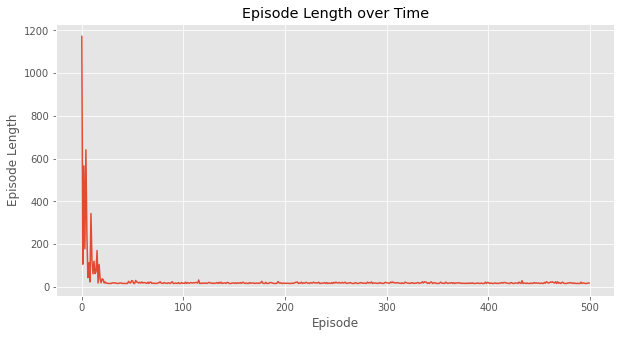

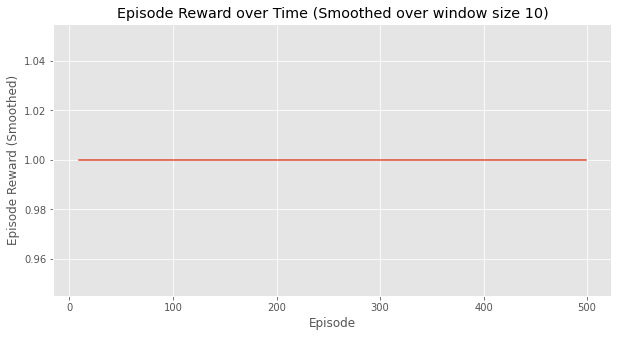

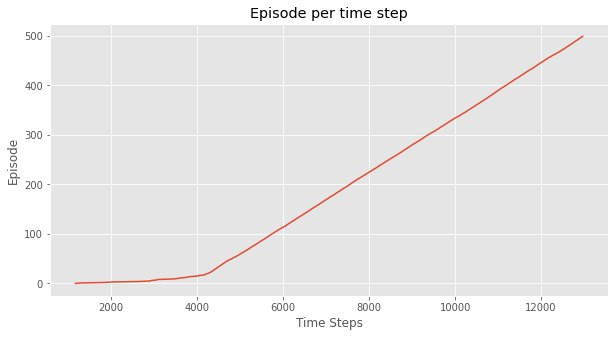

In [62]:
# Plot the episode length over time
fig1 = plt.figure(figsize=(10,5))
plt.plot(episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.title("Episode Length over Time")
plt.savefig("Episode Length over Time"+".png")
plt.show(fig1)

# Plot the episode reward over time
fig2 = plt.figure(figsize=(10,5))
rewards_smoothed = pd.Series(episode_rewards).rolling(10, min_periods=10).mean()
plt.plot(rewards_smoothed)
plt.xlabel("Episode")
plt.ylabel("Episode Reward (Smoothed)")
plt.title("Episode Reward over Time (Smoothed over window size {})".format(10))
plt.savefig("Episode Reward over Time"+".png")

plt.show(fig2)

# Plot time steps and episode number
fig3 = plt.figure(figsize=(10,5))
plt.plot(np.cumsum(episode_lengths), np.arange(len(episode_lengths)))
plt.xlabel("Time Steps")
plt.ylabel("Episode")
plt.title("Episode per time step")
plt.savefig("Episode per time step"+".png")
plt.show(fig3)